# <center> Лабораторная работа 3. CIFAR (Мигранов Денис Игоревич, группа 20225).  </center>

In [1]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tqdm import tqdm_notebook

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../pytorch_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../pytorch_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../pytorch_data/cifar-10-python.tar.gz to ../pytorch_data
Files already downloaded and verified


На всякий случай сразу аугментируем

In [4]:
batch_size = 4

transform_aug = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomRotation(30)])

trainset_temp = torchvision.datasets.CIFAR10(root='../pytorch_data', train=True, 
                                      download=True, transform=transform_aug)
trainset_aug = torch.utils.data.ConcatDataset([trainset,trainset_temp])
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



Files already downloaded and verified


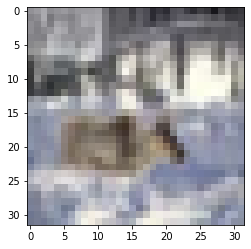

In [5]:
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i]);

In [6]:
trainloader.dataset.data[i].shape

(32, 32, 3)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
from tqdm import tqdm_notebook

In [ ]:
class ConvNet1(nn.Module):
    def __init__(self, channels1, channels2, channels3, kernel_size1, kernel_size2, kernel_size3, fc1, fc2, is_max_pool = True):
        # вызов конструктора класса nn.Module()
        super(ConvNet1, self).__init__()
        
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        #new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        new_size = new_size // 2

        print(new_size)

        self.fc1_size = new_size * new_size * channels3
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
#        print(x.shape)
        x = x.view(-1, self.fc1_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, train_loader, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(train_loader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('Обучение закончено')

    def predict(self, test_loader):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
              
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        print('\nTotal accuracy:', (100. * class_correct_t / class_total_t))

In [ ]:
net_1 = ConvNet1(6, 16, 32, 5, 5, 5, 120, 84) #с Max пулингом
net_1.train(trainloader)

3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.066
[1,  4000] loss: 1.842
[1,  6000] loss: 1.751
[1,  8000] loss: 1.698
[1, 10000] loss: 1.653
[1, 12000] loss: 1.622


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.567
[2,  4000] loss: 1.550
[2,  6000] loss: 1.540
[2,  8000] loss: 1.516
[2, 10000] loss: 1.470
[2, 12000] loss: 1.469


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.452
[3,  4000] loss: 1.408
[3,  6000] loss: 1.412
[3,  8000] loss: 1.399
[3, 10000] loss: 1.400
[3, 12000] loss: 1.363
Обучение закончено


In [ ]:
net_1.predict(testloader)

Accuracy of plane : 50 %
Accuracy of car : 57 %
Accuracy of bird : 38 %
Accuracy of cat : 21 %
Accuracy of deer : 30 %
Accuracy of dog : 57 %
Accuracy of frog : 63 %
Accuracy of horse : 57 %
Accuracy of ship : 65 %
Accuracy of truck : 65 %

Total accuracy: 50.74


Поиграем с количеством нейронов в слоях и подадим аугментированный датасет

In [ ]:
net_2 = ConvNet1(10, 20, 30, 5, 5, 5, 150, 100) #с Max пулингом
net_2.train(trainloader_aug, num_epochs=5, learning_rate=1e-3)

3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.971
[1,  4000] loss: 1.734
[1,  6000] loss: 1.673
[1,  8000] loss: 1.595
[1, 10000] loss: 1.578
[1, 12000] loss: 1.538
[1, 14000] loss: 1.513
[1, 16000] loss: 1.515
[1, 18000] loss: 1.491
[1, 20000] loss: 1.464
[1, 22000] loss: 1.446
[1, 24000] loss: 1.425


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.406
[2,  4000] loss: 1.412
[2,  6000] loss: 1.399
[2,  8000] loss: 1.396
[2, 10000] loss: 1.397
[2, 12000] loss: 1.381
[2, 14000] loss: 1.363
[2, 16000] loss: 1.391
[2, 18000] loss: 1.374
[2, 20000] loss: 1.369
[2, 22000] loss: 1.355
[2, 24000] loss: 1.366


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 1.329
[3,  4000] loss: 1.324
[3,  6000] loss: 1.324
[3,  8000] loss: 1.332
[3, 10000] loss: 1.322
[3, 12000] loss: 1.291
[3, 14000] loss: 1.335
[3, 16000] loss: 1.310
[3, 18000] loss: 1.354
[3, 20000] loss: 1.339
[3, 22000] loss: 1.341
[3, 24000] loss: 1.297


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 1.281
[4,  4000] loss: 1.318
[4,  6000] loss: 1.301
[4,  8000] loss: 1.284
[4, 10000] loss: 1.288
[4, 12000] loss: 1.289
[4, 14000] loss: 1.283
[4, 16000] loss: 1.267
[4, 18000] loss: 1.285
[4, 20000] loss: 1.310
[4, 22000] loss: 1.282
[4, 24000] loss: 1.307


  0%|          | 0/25000 [00:00<?, ?it/s]

[5,  2000] loss: 1.289
[5,  4000] loss: 1.269
[5,  6000] loss: 1.269
[5,  8000] loss: 1.259
[5, 10000] loss: 1.244
[5, 12000] loss: 1.260
[5, 14000] loss: 1.291
[5, 16000] loss: 1.261
[5, 18000] loss: 1.258
[5, 20000] loss: 1.273
[5, 22000] loss: 1.266
[5, 24000] loss: 1.250
Обучение закончено


In [ ]:
net_2.predict(testloader)

Accuracy of plane : 62 %
Accuracy of car : 67 %
Accuracy of bird : 41 %
Accuracy of cat : 39 %
Accuracy of deer : 52 %
Accuracy of dog : 35 %
Accuracy of frog : 64 %
Accuracy of horse : 69 %
Accuracy of ship : 82 %
Accuracy of truck : 59 %

Total accuracy: 57.51


Повысили на семь процентов!

Добавим ради интереса сюда дропаут и lrelu

In [9]:
from torch.nn import Dropout

In [10]:
class ConvNet2(nn.Module): #dropuot, lrelu
    def __init__(self, channels1, channels2, channels3, kernel_size1, kernel_size2, kernel_size3, fc1, fc2, dropout, is_max_pool = True):
        # вызов конструктора класса nn.Module()
        super(ConvNet2, self).__init__()
        
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        #new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        new_size = new_size // 2

        print(new_size)

        self.fc1_size = new_size * new_size * channels3
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(self.conv3(F.leaky_relu(self.conv2(x))))
#        print(x.shape)
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(F.leaky_relu(self.fc1(x)))
        x = self.dropout2(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def train(self, train_loader, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(train_loader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('Обучение закончено')

    def predict(self, test_loader):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
              
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        print('\nTotal accuracy:', (100. * class_correct_t / class_total_t))

In [ ]:
net_3 = ConvNet2(5, 15, 30, 3, 5, 7, 40, 80, 0.7) #с Max пулингом
net_3.train(trainloader_aug, num_epochs=5, learning_rate=1e-3)

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 2.235
[1,  4000] loss: 2.058
[1,  6000] loss: 2.022
[1,  8000] loss: 1.974
[1, 10000] loss: 1.943
[1, 12000] loss: 1.942
[1, 14000] loss: 1.924
[1, 16000] loss: 1.897
[1, 18000] loss: 1.891
[1, 20000] loss: 1.877
[1, 22000] loss: 1.876
[1, 24000] loss: 1.868


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.870
[2,  4000] loss: 1.849
[2,  6000] loss: 1.833
[2,  8000] loss: 1.821
[2, 10000] loss: 1.852
[2, 12000] loss: 1.835
[2, 14000] loss: 1.838
[2, 16000] loss: 1.822
[2, 18000] loss: 1.831
[2, 20000] loss: 1.844
[2, 22000] loss: 1.827
[2, 24000] loss: 1.832


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 1.815
[3,  4000] loss: 1.820
[3,  6000] loss: 1.806
[3,  8000] loss: 1.822
[3, 10000] loss: 1.773
[3, 12000] loss: 1.803
[3, 14000] loss: 1.799
[3, 16000] loss: 1.800
[3, 18000] loss: 1.807
[3, 20000] loss: 1.794
[3, 22000] loss: 1.776
[3, 24000] loss: 1.792


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 1.773
[4,  4000] loss: 1.794
[4,  6000] loss: 1.783
[4,  8000] loss: 1.779
[4, 10000] loss: 1.782
[4, 12000] loss: 1.777
[4, 14000] loss: 1.792
[4, 16000] loss: 1.783
[4, 18000] loss: 1.791
[4, 20000] loss: 1.780
[4, 22000] loss: 1.768
[4, 24000] loss: 1.770


  0%|          | 0/25000 [00:00<?, ?it/s]

[5,  2000] loss: 1.771
[5,  4000] loss: 1.779
[5,  6000] loss: 1.774
[5,  8000] loss: 1.783
[5, 10000] loss: 1.760
[5, 12000] loss: 1.768
[5, 14000] loss: 1.785
[5, 16000] loss: 1.770
[5, 18000] loss: 1.751
[5, 20000] loss: 1.771
[5, 22000] loss: 1.782
[5, 24000] loss: 1.774
Обучение закончено


In [ ]:
net_3.predict(testloader)

Accuracy of plane : 38 %
Accuracy of car : 26 %
Accuracy of bird : 14 %
Accuracy of cat : 33 %
Accuracy of deer : 34 %
Accuracy of dog : 17 %
Accuracy of frog : 58 %
Accuracy of horse : 24 %
Accuracy of ship : 49 %
Accuracy of truck : 51 %

Total accuracy: 34.71


Плохо (обучение медленное, застряли). 

In [20]:
net_4 = ConvNet2(20, 30, 40, 5, 5, 3, 50, 100, 0.3) #с Max пулингом
net_4.train(trainloader_aug, num_epochs=5, learning_rate=5e-4)

4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 2.019
[1,  4000] loss: 1.750
[1,  6000] loss: 1.661
[1,  8000] loss: 1.583
[1, 10000] loss: 1.544
[1, 12000] loss: 1.521
[1, 14000] loss: 1.470
[1, 16000] loss: 1.461
[1, 18000] loss: 1.449
[1, 20000] loss: 1.409
[1, 22000] loss: 1.409
[1, 24000] loss: 1.395


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.358
[2,  4000] loss: 1.356
[2,  6000] loss: 1.341
[2,  8000] loss: 1.344
[2, 10000] loss: 1.321
[2, 12000] loss: 1.318
[2, 14000] loss: 1.295
[2, 16000] loss: 1.321
[2, 18000] loss: 1.288
[2, 20000] loss: 1.278
[2, 22000] loss: 1.283
[2, 24000] loss: 1.265


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 1.258
[3,  4000] loss: 1.245
[3,  6000] loss: 1.253
[3,  8000] loss: 1.219
[3, 10000] loss: 1.201
[3, 12000] loss: 1.209
[3, 14000] loss: 1.232
[3, 16000] loss: 1.229
[3, 18000] loss: 1.216
[3, 20000] loss: 1.210
[3, 22000] loss: 1.235
[3, 24000] loss: 1.224


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 1.187
[4,  4000] loss: 1.182
[4,  6000] loss: 1.190
[4,  8000] loss: 1.195
[4, 10000] loss: 1.185
[4, 12000] loss: 1.180
[4, 14000] loss: 1.176
[4, 16000] loss: 1.171
[4, 18000] loss: 1.180
[4, 20000] loss: 1.170
[4, 22000] loss: 1.186
[4, 24000] loss: 1.177


  0%|          | 0/25000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd2b4db5320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd2b4db5320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[5,  2000] loss: 1.157
[5,  4000] loss: 1.149
[5,  6000] loss: 1.167
[5,  8000] loss: 1.149
[5, 10000] loss: 1.131
[5, 12000] loss: 1.140
[5, 14000] loss: 1.157
[5, 16000] loss: 1.131
[5, 18000] loss: 1.148
[5, 20000] loss: 1.149
[5, 22000] loss: 1.133
[5, 24000] loss: 1.129
Обучение закончено


In [21]:
net_4.predict(testloader)

Accuracy of plane : 60 %
Accuracy of car : 79 %
Accuracy of bird : 50 %
Accuracy of cat : 34 %
Accuracy of deer : 57 %
Accuracy of dog : 44 %
Accuracy of frog : 73 %
Accuracy of horse : 63 %
Accuracy of ship : 82 %
Accuracy of truck : 72 %

Total accuracy: 61.88


Улучшили ещё! Ради интереса, дообучим ещё

In [22]:
net_4.train(trainloader_aug, num_epochs=2, learning_rate=5e-4)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.126
[1,  4000] loss: 1.118
[1,  6000] loss: 1.119
[1,  8000] loss: 1.106
[1, 10000] loss: 1.119
[1, 12000] loss: 1.107
[1, 14000] loss: 1.129
[1, 16000] loss: 1.136
[1, 18000] loss: 1.112
[1, 20000] loss: 1.123
[1, 22000] loss: 1.149
[1, 24000] loss: 1.119


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.076
[2,  4000] loss: 1.094
[2,  6000] loss: 1.091
[2,  8000] loss: 1.107
[2, 10000] loss: 1.083
[2, 12000] loss: 1.097
[2, 14000] loss: 1.082
[2, 16000] loss: 1.106
[2, 18000] loss: 1.111
[2, 20000] loss: 1.085
[2, 22000] loss: 1.090
[2, 24000] loss: 1.121
Обучение закончено
Accuracy of plane : 65 %
Accuracy of car : 77 %
Accuracy of bird : 53 %
Accuracy of cat : 42 %
Accuracy of deer : 50 %
Accuracy of dog : 57 %
Accuracy of frog : 61 %
Accuracy of horse : 75 %
Accuracy of ship : 74 %
Accuracy of truck : 70 %

Total accuracy: 62.76


Ещё чуть улучшилось... Ну и ради интереса ещё дообучим, поменяв learning rate

In [23]:
net_4.train(trainloader_aug, num_epochs=4, learning_rate=1e-4)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.986
[1,  4000] loss: 0.974
[1,  6000] loss: 0.972
[1,  8000] loss: 0.976
[1, 10000] loss: 0.972
[1, 12000] loss: 0.919
[1, 14000] loss: 0.957
[1, 16000] loss: 0.937
[1, 18000] loss: 0.930
[1, 20000] loss: 0.938
[1, 22000] loss: 0.935
[1, 24000] loss: 0.932


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.925
[2,  4000] loss: 0.913
[2,  6000] loss: 0.928
[2,  8000] loss: 0.951
[2, 10000] loss: 0.910
[2, 12000] loss: 0.912
[2, 14000] loss: 0.918
[2, 16000] loss: 0.920
[2, 18000] loss: 0.910
[2, 20000] loss: 0.912
[2, 22000] loss: 0.929
[2, 24000] loss: 0.913


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.905
[3,  4000] loss: 0.880
[3,  6000] loss: 0.896
[3,  8000] loss: 0.914
[3, 10000] loss: 0.885
[3, 12000] loss: 0.905
[3, 14000] loss: 0.898
[3, 16000] loss: 0.910
[3, 18000] loss: 0.884
[3, 20000] loss: 0.886
[3, 22000] loss: 0.911
[3, 24000] loss: 0.887


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.902
[4,  4000] loss: 0.886
[4,  6000] loss: 0.889
[4,  8000] loss: 0.883
[4, 10000] loss: 0.891
[4, 12000] loss: 0.904
[4, 14000] loss: 0.874
[4, 16000] loss: 0.876
[4, 18000] loss: 0.875
[4, 20000] loss: 0.902
[4, 22000] loss: 0.893
[4, 24000] loss: 0.895
Обучение закончено
Accuracy of plane : 72 %
Accuracy of car : 78 %
Accuracy of bird : 54 %
Accuracy of cat : 48 %
Accuracy of deer : 61 %
Accuracy of dog : 58 %
Accuracy of frog : 73 %
Accuracy of horse : 74 %
Accuracy of ship : 83 %
Accuracy of truck : 75 %

Total accuracy: 67.99


Учитывая близость к рубежу в 70 процентов, дообучим ещё

In [24]:
net_4.train(trainloader_aug, num_epochs=4, learning_rate=1e-4)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.869
[1,  4000] loss: 0.875
[1,  6000] loss: 0.913
[1,  8000] loss: 0.867
[1, 10000] loss: 0.878
[1, 12000] loss: 0.880
[1, 14000] loss: 0.860
[1, 16000] loss: 0.880
[1, 18000] loss: 0.862
[1, 20000] loss: 0.865
[1, 22000] loss: 0.857
[1, 24000] loss: 0.890


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.850
[2,  4000] loss: 0.863
[2,  6000] loss: 0.850
[2,  8000] loss: 0.854
[2, 10000] loss: 0.860
[2, 12000] loss: 0.857
[2, 14000] loss: 0.846
[2, 16000] loss: 0.876
[2, 18000] loss: 0.861
[2, 20000] loss: 0.873
[2, 22000] loss: 0.865
[2, 24000] loss: 0.881


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.845
[3,  4000] loss: 0.833
[3,  6000] loss: 0.852
[3,  8000] loss: 0.864
[3, 10000] loss: 0.846
[3, 12000] loss: 0.877
[3, 14000] loss: 0.840
[3, 16000] loss: 0.855
[3, 18000] loss: 0.865
[3, 20000] loss: 0.870
[3, 22000] loss: 0.875
[3, 24000] loss: 0.856


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.837
[4,  4000] loss: 0.849
[4,  6000] loss: 0.842
[4,  8000] loss: 0.860
[4, 10000] loss: 0.841
[4, 12000] loss: 0.854
[4, 14000] loss: 0.867
[4, 16000] loss: 0.832
[4, 18000] loss: 0.855
[4, 20000] loss: 0.845
[4, 22000] loss: 0.847
[4, 24000] loss: 0.857
Обучение закончено
Accuracy of plane : 72 %
Accuracy of car : 83 %
Accuracy of bird : 56 %
Accuracy of cat : 45 %
Accuracy of deer : 69 %
Accuracy of dog : 61 %
Accuracy of frog : 75 %
Accuracy of horse : 73 %
Accuracy of ship : 82 %
Accuracy of truck : 76 %

Total accuracy: 69.65


In [25]:
net_4.train(trainloader_aug, num_epochs=2, learning_rate=5e-5)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.828
[1,  4000] loss: 0.843
[1,  6000] loss: 0.809
[1,  8000] loss: 0.822
[1, 10000] loss: 0.836
[1, 12000] loss: 0.823
[1, 14000] loss: 0.815
[1, 16000] loss: 0.818
[1, 18000] loss: 0.821
[1, 20000] loss: 0.816
[1, 22000] loss: 0.817
[1, 24000] loss: 0.829


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.812
[2,  4000] loss: 0.837
[2,  6000] loss: 0.830
[2,  8000] loss: 0.805
[2, 10000] loss: 0.817
[2, 12000] loss: 0.824
[2, 14000] loss: 0.794
[2, 16000] loss: 0.814
[2, 18000] loss: 0.819
[2, 20000] loss: 0.830
[2, 22000] loss: 0.808
[2, 24000] loss: 0.812
Обучение закончено
Accuracy of plane : 75 %
Accuracy of car : 83 %
Accuracy of bird : 58 %
Accuracy of cat : 50 %
Accuracy of deer : 64 %
Accuracy of dog : 58 %
Accuracy of frog : 73 %
Accuracy of horse : 73 %
Accuracy of ship : 80 %
Accuracy of truck : 79 %

Total accuracy: 69.67


In [26]:
net_4.train(trainloader_aug, num_epochs=2, learning_rate=1e-4)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.816
[1,  4000] loss: 0.816
[1,  6000] loss: 0.830
[1,  8000] loss: 0.854
[1, 10000] loss: 0.829
[1, 12000] loss: 0.844
[1, 14000] loss: 0.842
[1, 16000] loss: 0.830
[1, 18000] loss: 0.839
[1, 20000] loss: 0.847
[1, 22000] loss: 0.836
[1, 24000] loss: 0.842


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.823
[2,  4000] loss: 0.828
[2,  6000] loss: 0.827
[2,  8000] loss: 0.845
[2, 10000] loss: 0.828
[2, 12000] loss: 0.838
[2, 14000] loss: 0.831
[2, 16000] loss: 0.847
[2, 18000] loss: 0.829
[2, 20000] loss: 0.806
[2, 22000] loss: 0.855
[2, 24000] loss: 0.816
Обучение закончено
Accuracy of plane : 77 %
Accuracy of car : 83 %
Accuracy of bird : 55 %
Accuracy of cat : 53 %
Accuracy of deer : 65 %
Accuracy of dog : 57 %
Accuracy of frog : 68 %
Accuracy of horse : 74 %
Accuracy of ship : 82 %
Accuracy of truck : 71 %

Total accuracy: 68.96


In [27]:
net_4.train(trainloader_aug, num_epochs=2, learning_rate=5e-5)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.792
[1,  4000] loss: 0.811
[1,  6000] loss: 0.801
[1,  8000] loss: 0.788
[1, 10000] loss: 0.813
[1, 12000] loss: 0.819
[1, 14000] loss: 0.800
[1, 16000] loss: 0.811
[1, 18000] loss: 0.797
[1, 20000] loss: 0.822
[1, 22000] loss: 0.815
[1, 24000] loss: 0.804


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.816
[2,  4000] loss: 0.791
[2,  6000] loss: 0.782
[2,  8000] loss: 0.804
[2, 10000] loss: 0.790
[2, 12000] loss: 0.789
[2, 14000] loss: 0.786
[2, 16000] loss: 0.789
[2, 18000] loss: 0.799
[2, 20000] loss: 0.811
[2, 22000] loss: 0.816
[2, 24000] loss: 0.807
Обучение закончено
Accuracy of plane : 78 %
Accuracy of car : 83 %
Accuracy of bird : 56 %
Accuracy of cat : 51 %
Accuracy of deer : 62 %
Accuracy of dog : 54 %
Accuracy of frog : 74 %
Accuracy of horse : 73 %
Accuracy of ship : 77 %
Accuracy of truck : 79 %

Total accuracy: 69.18


In [28]:
net_4.train(trainloader_aug, num_epochs=4, learning_rate=5e-5)
net_4.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.801
[1,  4000] loss: 0.792
[1,  6000] loss: 0.782
[1,  8000] loss: 0.793
[1, 10000] loss: 0.801
[1, 12000] loss: 0.799
[1, 14000] loss: 0.786
[1, 16000] loss: 0.784
[1, 18000] loss: 0.794
[1, 20000] loss: 0.802
[1, 22000] loss: 0.805
[1, 24000] loss: 0.792


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.786
[2,  4000] loss: 0.797
[2,  6000] loss: 0.784
[2,  8000] loss: 0.794
[2, 10000] loss: 0.797
[2, 12000] loss: 0.798
[2, 14000] loss: 0.804
[2, 16000] loss: 0.797
[2, 18000] loss: 0.775
[2, 20000] loss: 0.787
[2, 22000] loss: 0.796
[2, 24000] loss: 0.804


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.792
[3,  4000] loss: 0.793
[3,  6000] loss: 0.791
[3,  8000] loss: 0.770
[3, 10000] loss: 0.787
[3, 12000] loss: 0.819
[3, 14000] loss: 0.765
[3, 16000] loss: 0.786
[3, 18000] loss: 0.769
[3, 20000] loss: 0.779
[3, 22000] loss: 0.796
[3, 24000] loss: 0.796


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.776
[4,  4000] loss: 0.788
[4,  6000] loss: 0.774
[4,  8000] loss: 0.785
[4, 10000] loss: 0.773
[4, 12000] loss: 0.798
[4, 14000] loss: 0.803
[4, 16000] loss: 0.784
[4, 18000] loss: 0.775
[4, 20000] loss: 0.785
[4, 22000] loss: 0.788
[4, 24000] loss: 0.806
Обучение закончено
Accuracy of plane : 75 %
Accuracy of car : 80 %
Accuracy of bird : 63 %
Accuracy of cat : 54 %
Accuracy of deer : 64 %
Accuracy of dog : 52 %
Accuracy of frog : 77 %
Accuracy of horse : 73 %
Accuracy of ship : 82 %
Accuracy of truck : 77 %

Total accuracy: 70.15


# Лучший результат для трёх сверточных слоев ↑

Итак, на архитектуре с тремя сверточными слоями и тремя полносвязными слоями с дропаутом добились средней точности 70.15. Использовалась функция активации LeakyReLU. Конструктор был вызван с такими параметрами: ConvNet2(20, 30, 40, 5, 5, 3, 50, 100, 0.3)

Наибольшие проблемы, как видно по вероятностям, с собаками и котами...

Поэкспериментируем теперь с количеством сверточных слоев. Добавим ещё сверточный слой (а количество полносвязных уменьшим - в MNIST так лучше было)

In [48]:
class ConvNet3(nn.Module): #dropuot, lrelu
    def __init__(self, channels1, channels2, channels3, channels4, kernel_size1, kernel_size2, kernel_size3, kernel_size4, fc1, dropout, is_max_pool = True):
        # вызов конструктора класса nn.Module()
        super(ConvNet3, self).__init__()
        
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        #new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2

        self.conv4 = nn.Conv2d(in_channels=channels3, out_channels=channels4, kernel_size=kernel_size4)
        new_size = new_size - kernel_size4 + 1
        new_size = new_size // 2

        #print(new_size)

        self.fc1_size = new_size * new_size * channels4
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)
        self.fc3 = nn.Linear(fc1, 10)

        self.dropout1 = Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv2(F.leaky_relu(self.conv1(x)))))
        x = self.pool(self.conv4(F.leaky_relu(self.conv3(x))))
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(F.leaky_relu(self.fc1(x)))
        #x = self.dropout2(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def train(self, train_loader, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(train_loader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('Обучение закончено')

    def predict(self, test_loader):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
              
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        print('\nTotal accuracy:', (100. * class_correct_t / class_total_t))

# Лучший результат для четырех сверточных слоев без batch normalization

In [50]:
net_5 = ConvNet3(20, 30, 40, 50, 3, 3, 3, 3, 100, 0.3) #с Max пулингом
net_5.train(trainloader_aug, num_epochs=4, learning_rate=5e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.863
[1,  4000] loss: 1.553
[1,  6000] loss: 1.466
[1,  8000] loss: 1.382
[1, 10000] loss: 1.336
[1, 12000] loss: 1.275
[1, 14000] loss: 1.227
[1, 16000] loss: 1.216
[1, 18000] loss: 1.177
[1, 20000] loss: 1.144
[1, 22000] loss: 1.118
[1, 24000] loss: 1.117


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.047
[2,  4000] loss: 1.052
[2,  6000] loss: 1.054
[2,  8000] loss: 1.024
[2, 10000] loss: 1.016
[2, 12000] loss: 1.025
[2, 14000] loss: 1.002
[2, 16000] loss: 1.017
[2, 18000] loss: 0.982
[2, 20000] loss: 0.977
[2, 22000] loss: 0.969
[2, 24000] loss: 0.985


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.936
[3,  4000] loss: 0.923
[3,  6000] loss: 0.929
[3,  8000] loss: 0.916
[3, 10000] loss: 0.919
[3, 12000] loss: 0.927
[3, 14000] loss: 0.917
[3, 16000] loss: 0.914
[3, 18000] loss: 0.912
[3, 20000] loss: 0.907
[3, 22000] loss: 0.926
[3, 24000] loss: 0.904


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.846
[4,  4000] loss: 0.881
[4,  6000] loss: 0.850
[4,  8000] loss: 0.878
[4, 10000] loss: 0.872
[4, 12000] loss: 0.884
[4, 14000] loss: 0.871
[4, 16000] loss: 0.870
[4, 18000] loss: 0.881
[4, 20000] loss: 0.882
[4, 22000] loss: 0.862
[4, 24000] loss: 0.858
Обучение закончено


In [51]:
net_5.predict(testloader)

Accuracy of plane : 73 %
Accuracy of car : 85 %
Accuracy of bird : 46 %
Accuracy of cat : 46 %
Accuracy of deer : 69 %
Accuracy of dog : 67 %
Accuracy of frog : 76 %
Accuracy of horse : 81 %
Accuracy of ship : 83 %
Accuracy of truck : 80 %

Total accuracy: 71.11


Достигли лучшего результата, и ошибка уменьшается быстрее, чем в предыдущем случае, так что дообучим ещё!

In [52]:
net_5.train(trainloader_aug, num_epochs=3, learning_rate=1e-4)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.723
[1,  4000] loss: 0.704
[1,  6000] loss: 0.705
[1,  8000] loss: 0.684
[1, 10000] loss: 0.688
[1, 12000] loss: 0.678
[1, 14000] loss: 0.715
[1, 16000] loss: 0.688
[1, 18000] loss: 0.693
[1, 20000] loss: 0.697
[1, 22000] loss: 0.687
[1, 24000] loss: 0.691


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.646
[2,  4000] loss: 0.647
[2,  6000] loss: 0.664
[2,  8000] loss: 0.677
[2, 10000] loss: 0.656
[2, 12000] loss: 0.658
[2, 14000] loss: 0.665
[2, 16000] loss: 0.663
[2, 18000] loss: 0.633
[2, 20000] loss: 0.664
[2, 22000] loss: 0.646
[2, 24000] loss: 0.664


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.632
[3,  4000] loss: 0.640
[3,  6000] loss: 0.632
[3,  8000] loss: 0.654
[3, 10000] loss: 0.625
[3, 12000] loss: 0.619
[3, 14000] loss: 0.623
[3, 16000] loss: 0.624
[3, 18000] loss: 0.651
[3, 20000] loss: 0.626
[3, 22000] loss: 0.630
[3, 24000] loss: 0.639
Обучение закончено
Accuracy of plane : 79 %
Accuracy of car : 86 %
Accuracy of bird : 61 %
Accuracy of cat : 49 %
Accuracy of deer : 70 %
Accuracy of dog : 65 %
Accuracy of frog : 78 %
Accuracy of horse : 80 %
Accuracy of ship : 85 %
Accuracy of truck : 83 %

Total accuracy: 74.12


Ещё лучше!

In [53]:
net_5.train(trainloader_aug, num_epochs=2, learning_rate=5e-5)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.603
[1,  4000] loss: 0.595
[1,  6000] loss: 0.615
[1,  8000] loss: 0.593
[1, 10000] loss: 0.610
[1, 12000] loss: 0.594
[1, 14000] loss: 0.603
[1, 16000] loss: 0.593
[1, 18000] loss: 0.588
[1, 20000] loss: 0.612
[1, 22000] loss: 0.594
[1, 24000] loss: 0.576


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.583
[2,  4000] loss: 0.576
[2,  6000] loss: 0.605
[2,  8000] loss: 0.585
[2, 10000] loss: 0.595
[2, 12000] loss: 0.584
[2, 14000] loss: 0.594
[2, 16000] loss: 0.577
[2, 18000] loss: 0.584
[2, 20000] loss: 0.575
[2, 22000] loss: 0.590
[2, 24000] loss: 0.572
Обучение закончено
Accuracy of plane : 80 %
Accuracy of car : 88 %
Accuracy of bird : 63 %
Accuracy of cat : 58 %
Accuracy of deer : 77 %
Accuracy of dog : 60 %
Accuracy of frog : 78 %
Accuracy of horse : 77 %
Accuracy of ship : 83 %
Accuracy of truck : 82 %

Total accuracy: 75.05


**Итак**, на сети с четырьмя сверточными слоями и двумя полносвязными получили точность 75.05%; параметры ConvNet3(20, 30, 40, 50, 3, 3, 3, 3, 100, 0.3); max pooling и leaky relu

Для интереса посмотрим как хорошо сходится значение функции потерь для одной эпохи с теми же параметрами, но Average Pooling:

In [54]:
net_5_avg = ConvNet3(20, 30, 40, 50, 3, 3, 3, 3, 100, 0.3, False) #с Max пулингом
net_5_avg.train(trainloader_aug, num_epochs=1, learning_rate=5e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.899
[1,  4000] loss: 1.613
[1,  6000] loss: 1.511
[1,  8000] loss: 1.442
[1, 10000] loss: 1.403
[1, 12000] loss: 1.360
[1, 14000] loss: 1.327
[1, 16000] loss: 1.278
[1, 18000] loss: 1.248
[1, 20000] loss: 1.211
[1, 22000] loss: 1.188
[1, 24000] loss: 1.141
Обучение закончено


Сходится совсем чуть похуже, чем вариант с max

# Batch normalization

Добавим сюда же ещё Batch Normalization и будем менять learning rate динамически, как в примере

In [55]:
from torch.optim import lr_scheduler

In [56]:
class ConvNet4(nn.Module): #dropuot, lrelu
    def __init__(self, channels1, channels2, channels3, channels4, kernel_size1, kernel_size2, kernel_size3, kernel_size4, fc1, dropout, is_max_pool = True):
        # вызов конструктора класса nn.Module()
        super(ConvNet4, self).__init__()
        
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        #new_size = new_size // 2
        self.bn1 = nn.BatchNorm2d(channels1)

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2 
        self.bn2 = nn.BatchNorm2d(channels2)

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2
        self.bn3 = nn.BatchNorm2d(channels3)

        self.conv4 = nn.Conv2d(in_channels=channels3, out_channels=channels4, kernel_size=kernel_size4)
        new_size = new_size - kernel_size4 + 1
        new_size = new_size // 2
        self.bn4 = nn.BatchNorm2d(channels4)
        #print(new_size)

        self.fc1_size = new_size * new_size * channels4
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)
        self.fc3 = nn.Linear(fc1, 10)

        self.dropout1 = Dropout(dropout)

    def forward(self, x):
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(self.bn1(F.leaky_relu(self.conv1(x)))))))
        x = self.pool(self.bn4(F.leaky_relu(self.conv4(self.bn3(F.leaky_relu(self.conv3(x)))))))
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(F.leaky_relu(self.fc1(x)))
        #x = self.dropout2(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def train(self, train_loader, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(train_loader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                scheduler.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('Обучение закончено')

    def predict(self, test_loader):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
              
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        print('\nTotal accuracy:', (100. * class_correct_t / class_total_t))

In [57]:
net_6 = ConvNet4(20, 30, 40, 50, 3, 3, 3, 3, 100, 0.3) #с Max пулингом
net_6.train(trainloader_aug, num_epochs=4, learning_rate=5e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.831
[1,  4000] loss: 1.618
[1,  6000] loss: 1.484
[1,  8000] loss: 1.426
[1, 10000] loss: 1.370
[1, 12000] loss: 1.341
[1, 14000] loss: 1.287
[1, 16000] loss: 1.261
[1, 18000] loss: 1.242
[1, 20000] loss: 1.213
[1, 22000] loss: 1.195
[1, 24000] loss: 1.142


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.114
[2,  4000] loss: 1.118
[2,  6000] loss: 1.090
[2,  8000] loss: 1.081
[2, 10000] loss: 1.087
[2, 12000] loss: 1.046
[2, 14000] loss: 1.060
[2, 16000] loss: 1.076
[2, 18000] loss: 1.027
[2, 20000] loss: 1.018
[2, 22000] loss: 1.027
[2, 24000] loss: 1.030


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.987
[3,  4000] loss: 0.974
[3,  6000] loss: 0.958
[3,  8000] loss: 0.959
[3, 10000] loss: 0.981
[3, 12000] loss: 0.951
[3, 14000] loss: 0.931
[3, 16000] loss: 0.963
[3, 18000] loss: 0.946
[3, 20000] loss: 0.933
[3, 22000] loss: 0.957
[3, 24000] loss: 0.953


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.885
[4,  4000] loss: 0.912
[4,  6000] loss: 0.884
[4,  8000] loss: 0.910
[4, 10000] loss: 0.915
[4, 12000] loss: 0.912
[4, 14000] loss: 0.906
[4, 16000] loss: 0.916
[4, 18000] loss: 0.914
[4, 20000] loss: 0.882
[4, 22000] loss: 0.900
[4, 24000] loss: 0.878
Обучение закончено


In [58]:
net_6.predict(testloader)

Accuracy of plane : 72 %
Accuracy of car : 85 %
Accuracy of bird : 54 %
Accuracy of cat : 45 %
Accuracy of deer : 68 %
Accuracy of dog : 65 %
Accuracy of frog : 74 %
Accuracy of horse : 77 %
Accuracy of ship : 79 %
Accuracy of truck : 78 %

Total accuracy: 70.18


In [60]:
net_6.train(trainloader, num_epochs=2, learning_rate=1e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 0.758
[1,  4000] loss: 0.728
[1,  6000] loss: 0.714
[1,  8000] loss: 0.705
[1, 10000] loss: 0.697
[1, 12000] loss: 0.695


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 0.662
[2,  4000] loss: 0.649
[2,  6000] loss: 0.639
[2,  8000] loss: 0.648
[2, 10000] loss: 0.645
[2, 12000] loss: 0.644
Обучение закончено


In [61]:
net_6.predict(testloader)

Accuracy of plane : 75 %
Accuracy of car : 83 %
Accuracy of bird : 59 %
Accuracy of cat : 52 %
Accuracy of deer : 69 %
Accuracy of dog : 63 %
Accuracy of frog : 77 %
Accuracy of horse : 77 %
Accuracy of ship : 82 %
Accuracy of truck : 81 %

Total accuracy: 72.02


In [62]:
net_6.train(trainloader_aug, num_epochs=1, learning_rate=1e-4)
net_6.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.758
[1,  4000] loss: 0.760
[1,  6000] loss: 0.784
[1,  8000] loss: 0.757
[1, 10000] loss: 0.753
[1, 12000] loss: 0.737
[1, 14000] loss: 0.745
[1, 16000] loss: 0.755
[1, 18000] loss: 0.752
[1, 20000] loss: 0.760
[1, 22000] loss: 0.735
[1, 24000] loss: 0.760
Обучение закончено
Accuracy of plane : 78 %
Accuracy of car : 84 %
Accuracy of bird : 59 %
Accuracy of cat : 49 %
Accuracy of deer : 70 %
Accuracy of dog : 64 %
Accuracy of frog : 77 %
Accuracy of horse : 79 %
Accuracy of ship : 83 %
Accuracy of truck : 82 %

Total accuracy: 72.99


In [64]:
net_6.train(trainloader_aug, num_epochs=3, learning_rate=5e-5)
net_6.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.763
[1,  4000] loss: 0.743
[1,  6000] loss: 0.727
[1,  8000] loss: 0.733
[1, 10000] loss: 0.735
[1, 12000] loss: 0.731
[1, 14000] loss: 0.729
[1, 16000] loss: 0.701
[1, 18000] loss: 0.720
[1, 20000] loss: 0.693
[1, 22000] loss: 0.706
[1, 24000] loss: 0.707


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.710
[2,  4000] loss: 0.701
[2,  6000] loss: 0.696
[2,  8000] loss: 0.732
[2, 10000] loss: 0.719
[2, 12000] loss: 0.719
[2, 14000] loss: 0.688
[2, 16000] loss: 0.699
[2, 18000] loss: 0.698
[2, 20000] loss: 0.722
[2, 22000] loss: 0.720
[2, 24000] loss: 0.693


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.708
[3,  4000] loss: 0.698
[3,  6000] loss: 0.687
[3,  8000] loss: 0.689
[3, 10000] loss: 0.698
[3, 12000] loss: 0.699
[3, 14000] loss: 0.676
[3, 16000] loss: 0.695
[3, 18000] loss: 0.706
[3, 20000] loss: 0.690
[3, 22000] loss: 0.720
[3, 24000] loss: 0.694
Обучение закончено
Accuracy of plane : 75 %
Accuracy of car : 87 %
Accuracy of bird : 61 %
Accuracy of cat : 51 %
Accuracy of deer : 69 %
Accuracy of dog : 64 %
Accuracy of frog : 78 %
Accuracy of horse : 78 %
Accuracy of ship : 86 %
Accuracy of truck : 82 %

Total accuracy: 73.66


В общем, без нормализации сходилось лучше, но тоже неплохо...

# Пять сверточных слоев

Добавим ещё один сверточный слой

In [65]:
class ConvNet5(nn.Module): #dropuot, lrelu
    def __init__(self, channels1, channels2, channels3, channels4, channels5, kernel_size1, kernel_size2, kernel_size3, kernel_size4, kernel_size5, fc1, dropout, is_max_pool = True):
        # вызов конструктора класса nn.Module()
        super(ConvNet5, self).__init__()
        
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        #new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2

        self.conv4 = nn.Conv2d(in_channels=channels3, out_channels=channels4, kernel_size=kernel_size4)
        new_size = new_size - kernel_size4 + 1
        #new_size = new_size // 2

        self.conv5 = nn.Conv2d(in_channels=channels4, out_channels=channels5, kernel_size=kernel_size5)
        new_size = new_size - kernel_size5 + 1
        #new_size = new_size // 2

        #print(new_size)

        self.fc1_size = new_size * new_size * channels5
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)
        self.fc3 = nn.Linear(fc1, 10)

        self.dropout1 = Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv2(F.leaky_relu(self.conv1(x)))))
        x = F.leaky_relu(self.conv4(F.leaky_relu(self.conv3(x))))
        x = F.leaky_relu(self.conv5(x))
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(F.leaky_relu(self.fc1(x)))
        #x = self.dropout2(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def train(self, train_loader, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(train_loader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                scheduler.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('Обучение закончено')

    def predict(self, test_loader):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(10):
            print('Accuracy of %2s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
              
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        print('\nTotal accuracy:', (100. * class_correct_t / class_total_t))

In [71]:
net_7 = ConvNet5(8, 16, 24, 32, 40, 3, 5, 3, 3, 1, 200, 0.3) #с Max пулингом
net_7.train(trainloader_aug, num_epochs=3, learning_rate=2e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 2.013
[1,  4000] loss: 1.752
[1,  6000] loss: 1.603
[1,  8000] loss: 1.541
[1, 10000] loss: 1.511
[1, 12000] loss: 1.489
[1, 14000] loss: 1.446
[1, 16000] loss: 1.408
[1, 18000] loss: 1.404
[1, 20000] loss: 1.376
[1, 22000] loss: 1.351
[1, 24000] loss: 1.372


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.306
[2,  4000] loss: 1.306
[2,  6000] loss: 1.289
[2,  8000] loss: 1.300
[2, 10000] loss: 1.297
[2, 12000] loss: 1.287
[2, 14000] loss: 1.281
[2, 16000] loss: 1.274
[2, 18000] loss: 1.248
[2, 20000] loss: 1.288
[2, 22000] loss: 1.264
[2, 24000] loss: 1.285


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 1.205
[3,  4000] loss: 1.214
[3,  6000] loss: 1.234
[3,  8000] loss: 1.240
[3, 10000] loss: 1.217
[3, 12000] loss: 1.200
[3, 14000] loss: 1.241
[3, 16000] loss: 1.230
[3, 18000] loss: 1.229
[3, 20000] loss: 1.225
[3, 22000] loss: 1.223
[3, 24000] loss: 1.247
Обучение закончено


In [72]:
net_7.predict(testloader)

Accuracy of plane : 66 %
Accuracy of car : 81 %
Accuracy of bird : 40 %
Accuracy of cat : 30 %
Accuracy of deer : 45 %
Accuracy of dog : 61 %
Accuracy of frog : 56 %
Accuracy of horse : 61 %
Accuracy of ship : 66 %
Accuracy of truck : 57 %

Total accuracy: 56.78


Очень плохо, и сходится плохо, медленнее, чем в предыдущих случаях с меньшим числом слоёв...

In [74]:
net_8 = ConvNet5(8, 16, 32, 64, 64, 3, 3, 5, 1, 1, 150, 0.2) #с Max пулингом
net_8.train(trainloader_aug, num_epochs=2, learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 1.908
[1,  4000] loss: 1.620
[1,  6000] loss: 1.473
[1,  8000] loss: 1.419
[1, 10000] loss: 1.373
[1, 12000] loss: 1.338
[1, 14000] loss: 1.305
[1, 16000] loss: 1.269
[1, 18000] loss: 1.238
[1, 20000] loss: 1.204
[1, 22000] loss: 1.211
[1, 24000] loss: 1.184


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 1.097
[2,  4000] loss: 1.104
[2,  6000] loss: 1.117
[2,  8000] loss: 1.095
[2, 10000] loss: 1.058
[2, 12000] loss: 1.045
[2, 14000] loss: 1.058
[2, 16000] loss: 1.052
[2, 18000] loss: 1.052
[2, 20000] loss: 1.049
[2, 22000] loss: 1.030
[2, 24000] loss: 1.006
Обучение закончено


In [75]:
net_8.predict(testloader)

Accuracy of plane : 67 %
Accuracy of car : 72 %
Accuracy of bird : 42 %
Accuracy of cat : 50 %
Accuracy of deer : 59 %
Accuracy of dog : 54 %
Accuracy of frog : 66 %
Accuracy of horse : 71 %
Accuracy of ship : 76 %
Accuracy of truck : 80 %

Total accuracy: 64.2


In [76]:
net_8.train(trainloader_aug, num_epochs=1, learning_rate=5e-4)
net_8.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.894
[1,  4000] loss: 0.873
[1,  6000] loss: 0.863
[1,  8000] loss: 0.861
[1, 10000] loss: 0.849
[1, 12000] loss: 0.843
[1, 14000] loss: 0.846
[1, 16000] loss: 0.850
[1, 18000] loss: 0.818
[1, 20000] loss: 0.846
[1, 22000] loss: 0.827
[1, 24000] loss: 0.843
Обучение закончено
Accuracy of plane : 71 %
Accuracy of car : 90 %
Accuracy of bird : 52 %
Accuracy of cat : 44 %
Accuracy of deer : 66 %
Accuracy of dog : 59 %
Accuracy of frog : 71 %
Accuracy of horse : 65 %
Accuracy of ship : 83 %
Accuracy of truck : 67 %

Total accuracy: 67.07


In [77]:
net_8.train(trainloader_aug, num_epochs=4, learning_rate=1e-4)
net_8.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.721
[1,  4000] loss: 0.713
[1,  6000] loss: 0.723
[1,  8000] loss: 0.719
[1, 10000] loss: 0.720
[1, 12000] loss: 0.703
[1, 14000] loss: 0.686
[1, 16000] loss: 0.699
[1, 18000] loss: 0.704
[1, 20000] loss: 0.686
[1, 22000] loss: 0.679
[1, 24000] loss: 0.718


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.656
[2,  4000] loss: 0.664
[2,  6000] loss: 0.669
[2,  8000] loss: 0.669
[2, 10000] loss: 0.679
[2, 12000] loss: 0.662
[2, 14000] loss: 0.685
[2, 16000] loss: 0.670
[2, 18000] loss: 0.664
[2, 20000] loss: 0.684
[2, 22000] loss: 0.673
[2, 24000] loss: 0.668


  0%|          | 0/25000 [00:00<?, ?it/s]

[3,  2000] loss: 0.642
[3,  4000] loss: 0.651
[3,  6000] loss: 0.651
[3,  8000] loss: 0.641
[3, 10000] loss: 0.648
[3, 12000] loss: 0.634
[3, 14000] loss: 0.643
[3, 16000] loss: 0.651
[3, 18000] loss: 0.664
[3, 20000] loss: 0.641
[3, 22000] loss: 0.651
[3, 24000] loss: 0.656


  0%|          | 0/25000 [00:00<?, ?it/s]

[4,  2000] loss: 0.621
[4,  4000] loss: 0.588
[4,  6000] loss: 0.639
[4,  8000] loss: 0.618
[4, 10000] loss: 0.631
[4, 12000] loss: 0.637
[4, 14000] loss: 0.621
[4, 16000] loss: 0.605
[4, 18000] loss: 0.622
[4, 20000] loss: 0.626
[4, 22000] loss: 0.628
[4, 24000] loss: 0.631
Обучение закончено
Accuracy of plane : 72 %
Accuracy of car : 84 %
Accuracy of bird : 58 %
Accuracy of cat : 51 %
Accuracy of deer : 63 %
Accuracy of dog : 57 %
Accuracy of frog : 72 %
Accuracy of horse : 74 %
Accuracy of ship : 80 %
Accuracy of truck : 78 %

Total accuracy: 69.28


In [78]:
net_8.train(trainloader_aug, num_epochs=2, learning_rate=1e-5)
net_8.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.589
[1,  4000] loss: 0.606
[1,  6000] loss: 0.609
[1,  8000] loss: 0.577
[1, 10000] loss: 0.580
[1, 12000] loss: 0.583
[1, 14000] loss: 0.587
[1, 16000] loss: 0.577
[1, 18000] loss: 0.583
[1, 20000] loss: 0.588
[1, 22000] loss: 0.589
[1, 24000] loss: 0.566


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.594
[2,  4000] loss: 0.586
[2,  6000] loss: 0.579
[2,  8000] loss: 0.583
[2, 10000] loss: 0.576
[2, 12000] loss: 0.586
[2, 14000] loss: 0.579
[2, 16000] loss: 0.572
[2, 18000] loss: 0.577
[2, 20000] loss: 0.586
[2, 22000] loss: 0.568
[2, 24000] loss: 0.583
Обучение закончено
Accuracy of plane : 73 %
Accuracy of car : 83 %
Accuracy of bird : 59 %
Accuracy of cat : 49 %
Accuracy of deer : 64 %
Accuracy of dog : 59 %
Accuracy of frog : 74 %
Accuracy of horse : 74 %
Accuracy of ship : 80 %
Accuracy of truck : 77 %

Total accuracy: 69.63


На четырех слоях достигали лучшего...

# Вернёмся к лучшему варианту

И немного потренируем ещё

In [80]:
net_5.train(trainloader_aug, num_epochs=2, learning_rate=5e-5)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.573
[1,  4000] loss: 0.554
[1,  6000] loss: 0.569
[1,  8000] loss: 0.599
[1, 10000] loss: 0.572
[1, 12000] loss: 0.581
[1, 14000] loss: 0.576
[1, 16000] loss: 0.579
[1, 18000] loss: 0.584
[1, 20000] loss: 0.552
[1, 22000] loss: 0.576
[1, 24000] loss: 0.590


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.582
[2,  4000] loss: 0.563
[2,  6000] loss: 0.561
[2,  8000] loss: 0.561
[2, 10000] loss: 0.573
[2, 12000] loss: 0.558
[2, 14000] loss: 0.564
[2, 16000] loss: 0.579
[2, 18000] loss: 0.565
[2, 20000] loss: 0.562
[2, 22000] loss: 0.580
[2, 24000] loss: 0.581
Обучение закончено
Accuracy of plane : 77 %
Accuracy of car : 87 %
Accuracy of bird : 63 %
Accuracy of cat : 54 %
Accuracy of deer : 69 %
Accuracy of dog : 67 %
Accuracy of frog : 82 %
Accuracy of horse : 81 %
Accuracy of ship : 85 %
Accuracy of truck : 85 %

Total accuracy: 75.45


In [81]:
net_5.train(trainloader_aug, num_epochs=2, learning_rate=1e-5)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.543
[1,  4000] loss: 0.543
[1,  6000] loss: 0.546
[1,  8000] loss: 0.530
[1, 10000] loss: 0.561
[1, 12000] loss: 0.533
[1, 14000] loss: 0.535
[1, 16000] loss: 0.546
[1, 18000] loss: 0.543
[1, 20000] loss: 0.557
[1, 22000] loss: 0.537
[1, 24000] loss: 0.536


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.547
[2,  4000] loss: 0.538
[2,  6000] loss: 0.546
[2,  8000] loss: 0.542
[2, 10000] loss: 0.537
[2, 12000] loss: 0.531
[2, 14000] loss: 0.525
[2, 16000] loss: 0.555
[2, 18000] loss: 0.538
[2, 20000] loss: 0.538
[2, 22000] loss: 0.532
[2, 24000] loss: 0.546
Обучение закончено
Accuracy of plane : 76 %
Accuracy of car : 87 %
Accuracy of bird : 64 %
Accuracy of cat : 54 %
Accuracy of deer : 72 %
Accuracy of dog : 65 %
Accuracy of frog : 78 %
Accuracy of horse : 79 %
Accuracy of ship : 84 %
Accuracy of truck : 86 %

Total accuracy: 75.07


In [85]:
net_5.train(trainloader_aug, num_epochs=2, learning_rate=5e-6)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.534
[1,  4000] loss: 0.534
[1,  6000] loss: 0.550
[1,  8000] loss: 0.527
[1, 10000] loss: 0.536
[1, 12000] loss: 0.551
[1, 14000] loss: 0.528
[1, 16000] loss: 0.533
[1, 18000] loss: 0.535
[1, 20000] loss: 0.544
[1, 22000] loss: 0.531
[1, 24000] loss: 0.530


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.531
[2,  4000] loss: 0.526
[2,  6000] loss: 0.541
[2,  8000] loss: 0.534
[2, 10000] loss: 0.538
[2, 12000] loss: 0.552
[2, 14000] loss: 0.525
[2, 16000] loss: 0.534
[2, 18000] loss: 0.539
[2, 20000] loss: 0.538
[2, 22000] loss: 0.541
[2, 24000] loss: 0.521
Обучение закончено
Accuracy of plane : 77 %
Accuracy of car : 87 %
Accuracy of bird : 64 %
Accuracy of cat : 55 %
Accuracy of deer : 73 %
Accuracy of dog : 66 %
Accuracy of frog : 81 %
Accuracy of horse : 79 %
Accuracy of ship : 84 %
Accuracy of truck : 85 %

Total accuracy: 75.51


In [86]:
net_5.train(trainloader_aug, num_epochs=2, learning_rate=5e-6)
net_5.predict(testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/25000 [00:00<?, ?it/s]

[1,  2000] loss: 0.526
[1,  4000] loss: 0.528
[1,  6000] loss: 0.539
[1,  8000] loss: 0.538
[1, 10000] loss: 0.522
[1, 12000] loss: 0.535
[1, 14000] loss: 0.533
[1, 16000] loss: 0.530
[1, 18000] loss: 0.528
[1, 20000] loss: 0.542
[1, 22000] loss: 0.522
[1, 24000] loss: 0.542


  0%|          | 0/25000 [00:00<?, ?it/s]

[2,  2000] loss: 0.534
[2,  4000] loss: 0.536
[2,  6000] loss: 0.539
[2,  8000] loss: 0.524
[2, 10000] loss: 0.524
[2, 12000] loss: 0.526
[2, 14000] loss: 0.527
[2, 16000] loss: 0.531
[2, 18000] loss: 0.530
[2, 20000] loss: 0.530
[2, 22000] loss: 0.524
[2, 24000] loss: 0.524
Обучение закончено
Accuracy of plane : 77 %
Accuracy of car : 88 %
Accuracy of bird : 62 %
Accuracy of cat : 57 %
Accuracy of deer : 74 %
Accuracy of dog : 66 %
Accuracy of frog : 82 %
Accuracy of horse : 80 %
Accuracy of ship : 84 %
Accuracy of truck : 85 %

Total accuracy: 75.91


# **Итого**

Были рассмотрены различные варианты архитектур: с двумя, тремя и четырьмя сверточными слоями, с тремя и двумя полносвязными слоями, с функциями активации ReLu и LReLU, с дропаутом и без, с max и average пулингом



Лучший результат был получен на сети с четырьмя сверточными слоями с max pooling и двумя полносвязными с дропаутом, получили точность 75.91%; использовалась функция активации leaky relu. Конструктор вызывался с параметрами: ConvNet3(20, 30, 40, 50, 3, 3, 3, 3, 100, 0.3); первые четыре - число каналов, следующие четыре - размеры ядер, 100 - количество нейронов в полносвязном слое, 0.3 - вероятность дропаута.